# [Modeling] Spatial Contexts for Los Angeles

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import statsmodels
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from matplotlib import rcParams
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

%matplotlib inline
plt.style.use('fivethirtyeight')

## Data Modeling

Here we will use of CalEPA data for Los Angeles to draw inference and predictions using various models, including unsupervised and supervised models.

In [2]:
ces_la = pd.read_csv("../data/CalEPA/ces_losangeles.csv", index_col=0).dropna()
ces_la["CES 4.0 Percentile Range"] = ces_la['CES 4.0 Percentile Range'].replace("1-5% (lowest scores)", "00-05%").replace("5-10%", "05-10%").replace("95-100% (highest scores)", "95-100%")

In [3]:
ces_la

,Census Tract,Total Population,California County,ZIP,Approximate Location,Longitude,Latitude,CES 4.0 Score,CES 4.0 Percentile Range,Ozone,...,CES 4.0 Percentile,Children < 10 years (%),Pop 10-64 years (%),Elderly > 64 years (%),Hispanic (%),White (%),African American (%),Native American (%),Asian American (%),Other/Multiple (%)
0,6037204920,2751,Los Angeles,90023,Los Angeles,-118.197497,34.017500,82.39,95-100%,0.048,...,99.97,13.34,72.59,14.07,97.27,1.71,0.84,0.00,0.00,0.18
2,6037543202,5124,Los Angeles,90220,Compton,-118.230032,33.879862,79.29,95-100%,0.042,...,99.91,18.60,72.48,8.92,78.14,1.09,15.67,0.00,4.84,0.25
3,6037203300,2000,Los Angeles,90033,Los Angeles,-118.207788,34.058872,77.35,95-100%,0.049,...,99.87,7.70,84.50,7.80,75.55,2.85,10.45,0.00,6.95,4.20
4,6037291220,3640,Los Angeles,90247,Los Angeles,-118.286709,33.877139,77.25,95-100%,0.041,...,99.86,12.77,73.16,14.07,69.34,3.98,8.43,0.00,16.32,1.92
5,6037433501,1949,Los Angeles,91733,South El Monte,-118.065122,34.057255,76.91,95-100%,0.055,...,99.85,10.98,75.42,13.60,93.89,0.72,0.00,0.00,5.39,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2055,6037262604,5523,Los Angeles,90272,Los Angeles,-118.548578,34.051108,3.85,00-05%,0.051,...,1.31,14.01,58.34,27.65,3.31,86.24,0.00,0.00,5.63,4.82
2056,6037670702,5649,Los Angeles,90275,Rancho Palos Verdes,-118.328443,33.753600,3.53,00-05%,0.039,...,1.02,7.97,65.59,26.45,8.43,68.53,1.12,0.42,15.29,6.21
2057,6037620904,2897,Los Angeles,90266,Manhattan Beach,-118.410369,33.880731,3.08,00-05%,0.043,...,0.72,12.60,70.80,16.60,4.42,85.71,0.00,0.00,2.35,7.53
2058,6037262802,3424,Los Angeles,90272,Los Angeles,-118.502456,34.045865,2.23,00-05%,0.050,...,0.34,11.42,61.89,26.69,10.72,80.96,0.32,0.00,2.98,5.02


One important detail before moving forward: the CES 4.0 Percentile Ranges are updated from 5% increments to 10% increments to better align with the work of the CalEPA CalEnviroScreen 4.0. 

In [4]:
temp_range = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
new_range = np.array(['00-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-100%'])

In [5]:
ranges = ces_la['CES 4.0 Percentile Range'].to_numpy()

for i in np.arange(len(ranges)):
    index = len(int(ranges[i][:2]) < temp_range) - sum(int(ranges[i][:2]) < temp_range)
    ranges[i] = new_range[index]

In [6]:
ces_la['CES 4.0 Percentile Range'] = ranges

In [7]:
# Confirm changes 

np.unique(ces_la['CES 4.0 Percentile Range'].to_numpy(), return_counts=True)

(array(['00-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-60%',
        '60-70%', '70-80%', '80-90%', '90-100%'], dtype=object),
 array([ 50,  73,  84, 125, 176, 177, 212, 278, 339, 456]))

## 1. Unsupervised Modeling

**What might be a use case for unsupervised modeling?** Without telling our models about the CES 4.0 Scores nor corresponding CES 4.0 Percentile Range, can they learn about them? 

## A. Principal Component Analysis

Why PCA? We are:

1. Visually identifying clusters of similar observations in high dimensions.
2. We have reason to believe that the data are inherently low rank: there are many attributes, but only a few  attributes mostly determine the rest through a linear association.

Are there features we should be aware of that guide our understanding of the CES 4.0 Scores?


In [8]:
from sklearn.decomposition import PCA

In [9]:
def pca_fit_df(df):
    """Performs PCA fit transform for the given DataFrame and assigns original CES 4.0 Percentile Range"""
    
    # PCA Projection onto 2D from df
    pca = PCA(n_components=2)
    pca.fit(df)
    
    pca_vals = pca.transform(df)
    pca_tbl = pd.DataFrame(pca_vals, columns=['x','y'])
    
    # Target
    pca_tbl['CES 4.0 Percentile Range'] = ces_la['CES 4.0 Percentile Range'].to_numpy()
    
    print('Explained variance ratio: ' + str(pca.explained_variance_ratio_))
    
    return pca_tbl

In [10]:
def pca_visualization(pca_df, indicator_str):
    """Plots PCA using PCA Dataframe from func: pca_fit_df"""
    
    rcParams['figure.figsize'] = 8,8

    sns.scatterplot(data=pca_df, x='x', y='y', hue='CES 4.0 Percentile Range', palette=sns.color_palette("RdYlGn", 10))
    plt.title('PCA by CES 4.0 Percentile Range using \n' + indicator_str)
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

In [11]:
# All features

identifiers = ['Census Tract', 'Total Population', 'California County', 'ZIP', 'Approximate Location', 'Longitude', 'Latitude', 'CES 4.0 Score', 'CES 4.0 Percentile Range', 'CES 4.0 Percentile']
pctl = list(ces_la.filter(regex = 'Pctl'))

indicators = ['Asthma', 'Low Birth Weight', 'Cardiovascular Disease', 'Education', 'Linguistic Isolation', 'Poverty', 'Unemployment', 'Housing Burden', 'Ozone', 'PM2.5', 'Diesel PM', 'Drinking Water', 'Lead', 'Pesticides', 'Tox. Release', 'Traffic', 'Cleanup Sites', 'Groundwater Threats', 'Haz. Waste', 'Imp. Water Bodies', 'Solid Waste']
demographics = ['Children < 10 years (%)', 'Pop 10-64 years (%)', 'Elderly > 64 years (%)', 'Hispanic (%)', 'White (%)', 'African American (%)', 'Native American (%)', 'Asian American (%)', 'Other/Multiple (%)']

In [12]:
# Indicators and demographics

df_pca = ces_la.drop(columns=identifiers).drop(columns=pctl)
df_pca = df_pca[indicators + demographics]

df_cols = list(df_pca.columns)

Our data is in different scales and measurements for the indicators and demographics.

PCA is effected by scale, so we need to scale the features in our data before applying PCA. So we will use StandardScaler to standardize the dataset's features onto unit scale (i.e., mean of 0 and variance of 1) for optimal performance.

In [13]:
# Standardize data

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_pca)
df_pca = pd.DataFrame(df_scaled)
df_pca = df_pca.set_axis(df_cols, axis=1)

In [14]:
df_pca

,Asthma,Low Birth Weight,Cardiovascular Disease,Education,Linguistic Isolation,Poverty,Unemployment,Housing Burden,Ozone,PM2.5,...,Solid Waste,Children < 10 years (%),Pop 10-64 years (%),Elderly > 64 years (%),Hispanic (%),White (%),African American (%),Native American (%),Asian American (%),Other/Multiple (%)
0,0.777447,1.067510,1.444528,1.843032,0.301305,1.480260,0.081442,-0.285816,-0.436243,0.618671,...,0.648418,0.368427,-0.411157,0.119770,1.733548,-1.003220,-0.594516,-0.398841,-0.941614,-1.062081
1,2.158325,0.589247,0.870599,1.296753,-0.392788,1.162538,2.093843,0.781994,-1.172030,0.577184,...,-0.108667,1.678092,-0.431962,-0.768747,1.058570,-1.027979,0.709422,-0.398841,-0.629891,-1.031497
2,0.395656,0.492384,-0.138578,1.836894,1.361205,1.978754,1.866637,0.632730,-0.313612,1.004402,...,-0.397081,-1.035853,1.841468,-0.961977,0.967185,-0.957694,0.250450,-0.398841,-0.493995,0.694337
3,0.368205,1.467071,-0.236722,0.578611,0.582695,0.872206,-0.535262,0.380130,-1.294661,0.398572,...,0.492194,0.226505,-0.303348,0.119770,0.748073,-0.912568,0.072840,-0.398841,0.109486,-0.301841
4,0.409743,0.153362,0.552698,1.843032,1.633214,1.398090,2.028927,1.137931,0.422175,0.325167,...,0.203781,-0.219180,0.124102,0.038682,1.614289,-1.042755,-0.668374,-0.398841,-0.594467,-1.140727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1965,-1.534250,-1.360128,-1.316306,-1.299607,-1.265094,-1.368281,-1.444088,-1.766972,-0.068350,-0.570424,...,-0.517253,0.535247,-3.106363,2.462693,-1.581713,2.372462,-0.668374,-0.398841,-0.579010,0.965227
1966,-1.486933,-1.208779,-1.516862,-1.219814,-0.852390,-1.735305,-1.444088,-2.421436,-1.539923,-0.386627,...,-0.469184,-0.968627,-1.735117,2.255660,-1.401061,1.665218,-0.569897,0.447879,0.043149,1.572546
1967,-1.519441,-2.183467,-1.320574,-1.360987,-1.302613,-1.587400,-0.502804,-1.399553,-1.049399,0.176843,...,-0.517253,0.184177,-0.749712,0.556265,-1.542548,2.351296,-0.668374,-0.398841,-0.790261,2.149280
1968,-1.652363,-2.486165,-1.924373,-1.360987,-1.302613,-1.554532,-0.697552,-1.755490,-0.190981,-0.463053,...,-0.517253,-0.109626,-2.434925,2.297067,-1.320261,2.161606,-0.640237,-0.398841,-0.749685,1.052611


In [15]:
# Features used for PCA (i.e., removed identifiers, percentiles, and aggregated scores)

features = list(df_pca.columns)
features

['Asthma',
 'Low Birth Weight',
 'Cardiovascular Disease',
 'Education',
 'Linguistic Isolation',
 'Poverty',
 'Unemployment',
 'Housing Burden',
 'Ozone',
 'PM2.5',
 'Diesel PM',
 'Drinking Water',
 'Lead',
 'Pesticides',
 'Tox. Release',
 'Traffic',
 'Cleanup Sites',
 'Groundwater Threats',
 'Haz. Waste',
 'Imp. Water Bodies',
 'Solid Waste',
 'Children < 10 years (%)',
 'Pop 10-64 years (%)',
 'Elderly > 64 years (%)',
 'Hispanic (%)',
 'White (%)',
 'African American (%)',
 'Native American (%)',
 'Asian American (%)',
 'Other/Multiple (%)']

### PCA using all indicators and demographics

Explained variance ratio: [0.24447236 0.08901719]


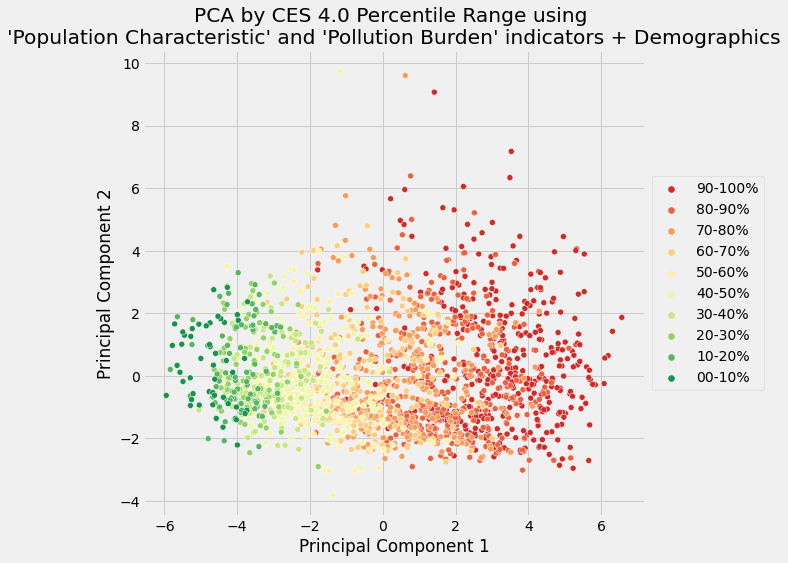

In [16]:
pca_all = pca_fit_df(df_pca)

pca_visualization(pca_all, "'Population Characteristic' and 'Pollution Burden' indicators + Demographics")

From this, we learn that our data does inheriently cluster in a 2D space for each of the CES 4.0 Percentile Ranges.

How much information do we lose? There are different ways to determine it. One of such was is a Scree Plot, but it is met with criticism based on the form of standardization performed [(source)](https://en.wikipedia.org/wiki/Scree_plot).

### PCA using 'Population Characteristic' indicators and 'Pollution Burden' indicators

What results when we use just indicator data? Can we reduce our data to 2D and still be able to predict an approximate CES 4.0 Percentile Range?

In [17]:
# Indicators

df_indicators = df_pca[indicators]

Explained variance ratio: [0.23019017 0.1220508 ]


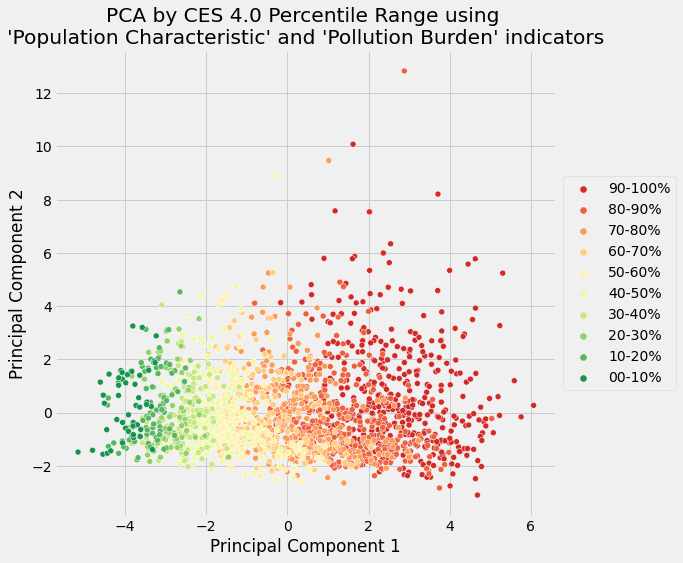

In [18]:
pca_indicators = pca_fit_df(df_indicators)

pca_visualization(pca_indicators, "'Population Characteristic' and 'Pollution Burden' indicators")

### PCA using 'Population Characteristic' Indicators 

Next, is it possible to get similar results just using population characteristic data? Can we reduce our data to 2D and still be able to predict an approximate CES 4.0 Percentile Range?

In [19]:
sensitive = ['Asthma', 'Low Birth Weight', 'Cardiovascular Disease']
socioeconomic = ['Education', 'Linguistic Isolation', 'Poverty', 'Unemployment', 'Housing Burden']

In [20]:
# Population Characteristics

df_population = df_pca[sensitive + socioeconomic]

Explained variance ratio: [0.50395766 0.16104682]


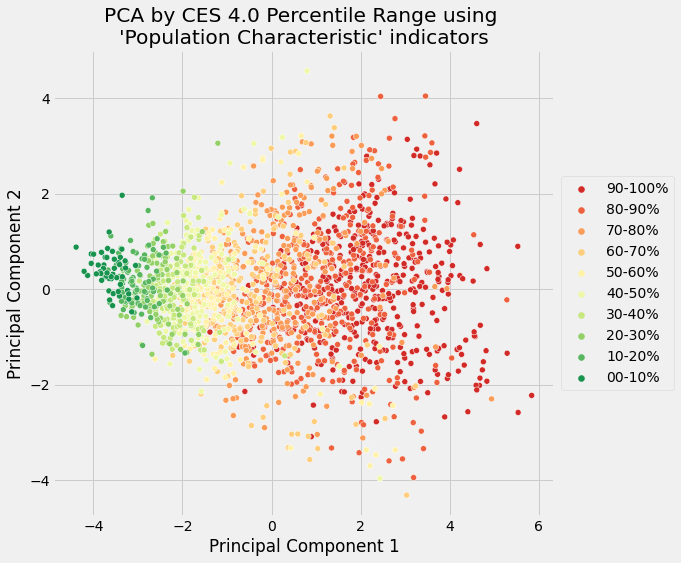

In [47]:
pca_population = pca_fit_df(df_population)

pca_visualization(pca_population, "'Population Characteristic' indicators")

#### Breakdown of Population Charactierstics

In [22]:
# Sensitive Indicators

df_population_sens = df_pca[sensitive]

Explained variance ratio: [0.65997399 0.25592611]


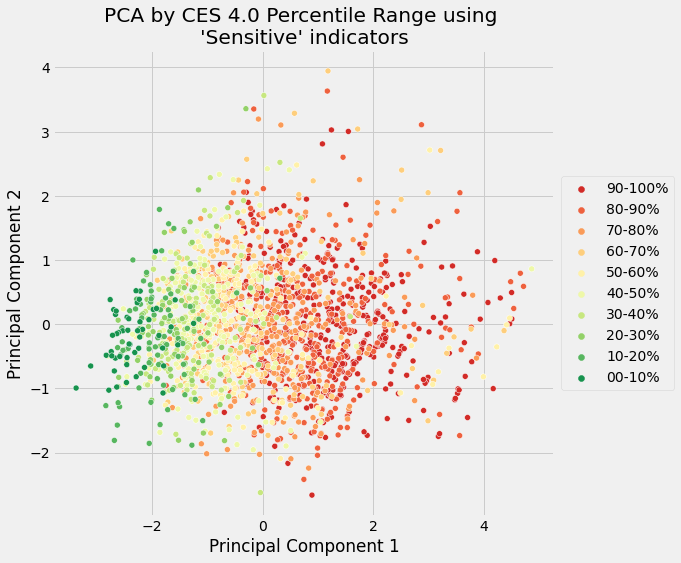

In [23]:
pca_population_sens = pca_fit_df(df_population_sens)

pca_visualization(pca_population_sens, "'Sensitive' indicators")

In [24]:
# Socioeconomic Indicators

df_population_se = df_pca[socioeconomic]

Explained variance ratio: [0.63328114 0.17183006]


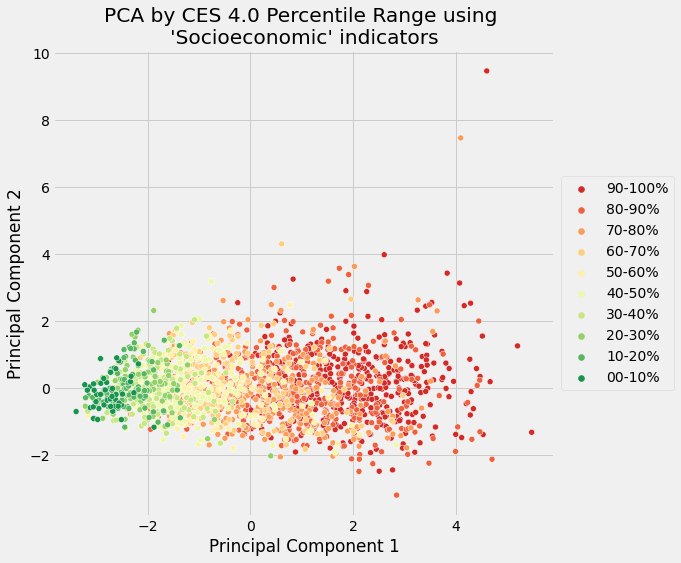

In [25]:
pca_population_se = pca_fit_df(df_population_se)

pca_visualization(pca_population_se, "'Socioeconomic' indicators")

### PCA using 'Pollution Burden' Indicators

Next, is it possible to get similar results just using pollution burden data? Can we reduce our data to 2D and still be able to predict an approximate CES 4.0 Percentile Range?

In [26]:
exposures = ['Ozone', 'PM2.5', 'Diesel PM', 'Drinking Water', 'Lead', 'Pesticides', 'Tox. Release', 'Traffic']
effects = ['Cleanup Sites', 'Groundwater Threats', 'Haz. Waste', 'Imp. Water Bodies', 'Solid Waste']

In [27]:
# Pollution Burden

df_pollution = df_pca[exposures + effects]

Explained variance ratio: [0.20943864 0.14800466]


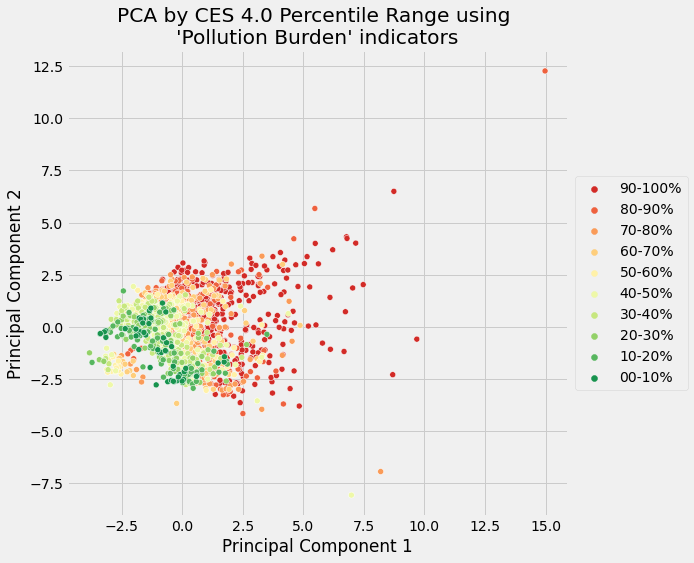

In [28]:
pca_pollution = pca_fit_df(df_pollution)

pca_visualization(pca_pollution, "'Pollution Burden' indicators")

#### Breakdown of Pollution Burden

One important consideration from the CalEPA CalEnviroScreen 4.0 is that pollution burden and population characteristics are broken down: exposures and effects, as well as sensitive factors and socioeconomic factors. In fact, in calculating the scores, environmental effects are weighted half as much as exposures. Is a PCA model able to identify these distinctions?

In [29]:
# Exposure Indicators

df_pollution_exp = df_pca[exposures]

Explained variance ratio: [0.26292358 0.21620476]


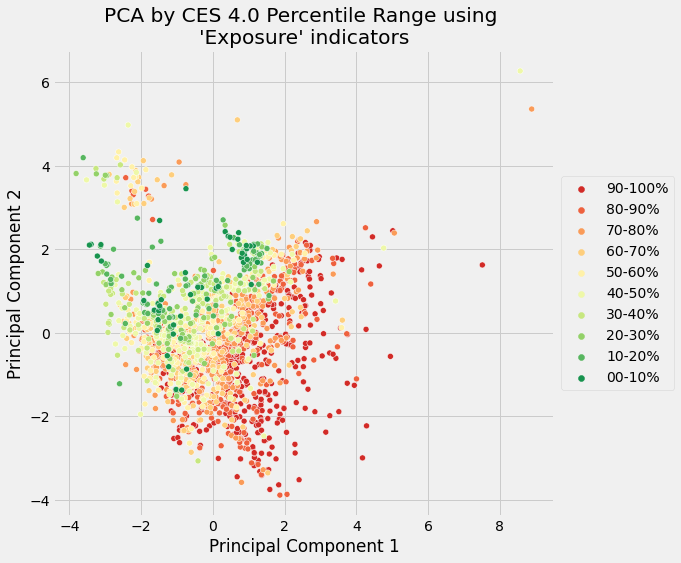

In [30]:
pca_pollution_exp = pca_fit_df(df_pollution_exp)

pca_visualization(pca_pollution_exp, "'Exposure' indicators")

In [31]:
# Effect Indicators

df_pollution_eff = df_pca[effects]

Explained variance ratio: [0.42997109 0.18938093]


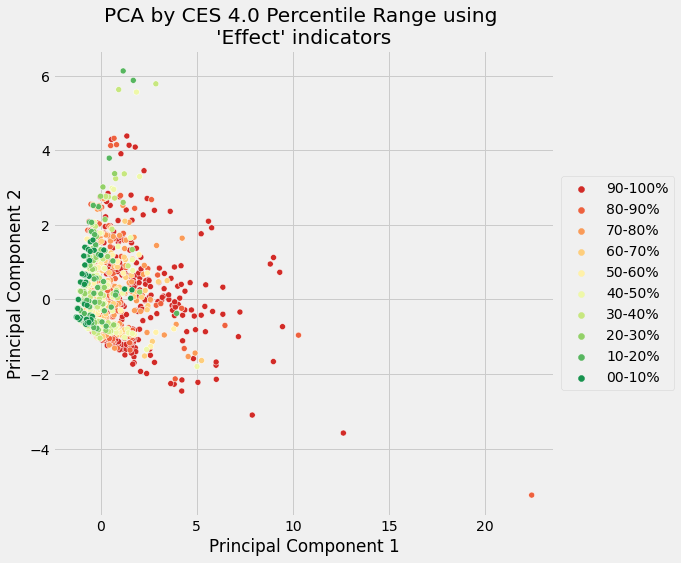

In [32]:
pca_pollution_eff = pca_fit_df(df_pollution_eff)

pca_visualization(pca_pollution_eff, "'Effect' indicators")

## B. Clustering

Why Clustering? We are:
1. Determining if a model can identify all possible CES 4.0 Percentile Range using the PCA-transformed data.
2. Visually identifying if it can seperate our data similarly to other methods such as PCA.

We implement the KMeans method for Clustering since it is a general-purpose method where we can specify the number of clusters, or classes. The limitation is that it aims to have even cluster sizes but the class of CES 4.0 Percentile Range is not even for the data.

In [53]:
from sklearn.cluster import KMeans

In [54]:
df_clustering = pca_indicators.copy()

In [70]:
kmeans_clusters = KMeans(n_clusters=10, random_state=1868).fit_predict(df_clustering.iloc[:, :2])

In [71]:
df_clustering['Cluster'] = kmeans_clusters + 1
df_clustering = df_clustering.sort_values("Cluster", ascending=True)
df_clustering['Cluster'] = df_clustering['Cluster'].apply(str)

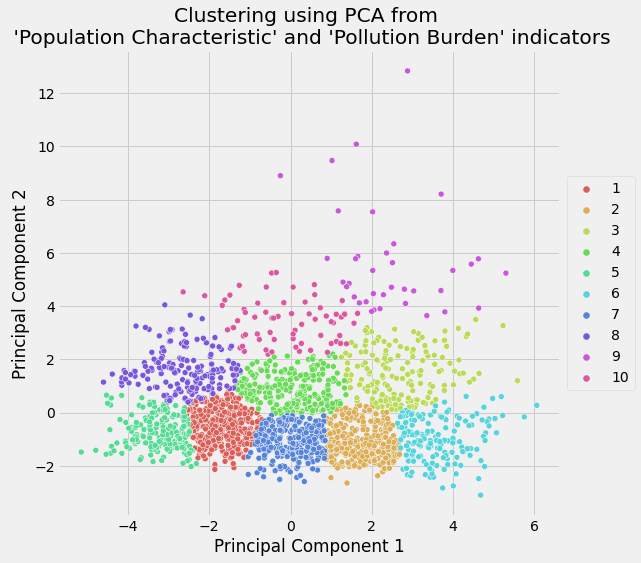

In [75]:
# Visualization

rcParams['figure.figsize'] = 8,8

sns.scatterplot(data=df_clustering, x='x', y='y', hue='Cluster', palette=sns.color_palette("hls", 10))
plt.title("KMeans Clustering using PCA from \n 'Population Characteristic' and 'Pollution Burden' indicators")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

Clustering via KMeans does not perform as well according to the observed differences with the first PCA using all features.

## 2. Supervised Modeling

**What might be a use case for supervised modeling?** As census tracts change, both in population characteristics and pollution burden, are there examples in which we can predict how it will compare to surrounding communities? Additionally, is it possible to predict using the PCA-transformed data? If so, then it might take less indicators than the CalEPA uses to predict and describe the CES 4.0 Percentile Range. If not, then we extract too much information using PCA-transformed data.

The target 'CES 4.0 Percentile Range' remains in the context of the state of California. Therefore, the result of the classification is how would a specific County of Los Angeles census tract compare to the rest of the state of California given certain indicators or demographics.

## A. Classification using K-Nearest Neighbors

Given our spatial data created from PCA, we will use k-Nearest Neighbors classification. 

Why KNN?
1. A simple and interpretable classification model based on distance.
2. PCA-transformed data has complex relations and outliers to be considered.

In [38]:
from sklearn.neighbors import KNeighborsClassifier

In [39]:
def knn_train_test_k(df):
    """Returns a DataFrame with data and predictions."""
    
    X = df.drop(columns=['CES 4.0 Percentile Range'])
    y = df['CES 4.0 Percentile Range']
    
    min_k = 3
    max_k = 100
    
    records = {}
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
    
    for k in np.arange(min_k, max_k+1, 2):

        neighbors_all = KNeighborsClassifier(n_neighbors=k)
        neighbors_all.fit(X_train, y_train)

        y_pred = neighbors_all.predict(X_test)
        
        records[k] = accuracy_score(y_test, y_pred)
        
    rcParams['figure.figsize'] = 6,4
    plt.plot(records.keys(), records.values())
    plt.title("KNN K-Values and Accuracy")
    plt.xlabel("K-Values")
    plt.ylabel("Accuracy")
    
    return max(records, key=records.get)

In [40]:
def knn_predictions(df, k):
    """Returns knn predictions for given data and k."""
    
    X = df.drop(columns=['CES 4.0 Percentile Range'])
    y = df['CES 4.0 Percentile Range']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
    
    # Train on selected k
    neighbors_all = KNeighborsClassifier(n_neighbors=k)
    neighbors_all.fit(X_train, y_train)
    
    # Predict for entire X
    y_pred = neighbors_all.predict(X)
    
    result_df = pd.concat([X, y], axis=1)
    result_df['Predicted CES 4.0 Percentile Range'] = y_pred
    
    return result_df
    

In [86]:
def prediction_visualization(pca_df, indicator_str):
    """Plots PCA using PCA Dataframe from func: pca_fit_df"""
    
    rcParams['figure.figsize'] = 8,8

    sns.scatterplot(data=pca_df, x='x', y='y', hue='Predicted CES 4.0 Percentile Range', palette=sns.color_palette("RdYlGn", 10))
    plt.title('Predicted CES 4.0 Percentile Range using KNN on \n' + indicator_str)
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

### Classification using 'Population Characteristic' and 'Pollution Burden' indicators

53

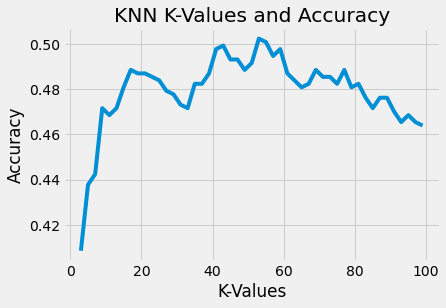

In [41]:
# Examine KNN accuracy with k

knn_train_test_k(pca_indicators)

No clear k that is great for predictions. Let's cutoff at k=21.

In [42]:
# Select a k of 21

knn_indicators = knn_predictions(pca_indicators, 21)
knn_indicators

,x,y,CES 4.0 Percentile Range,Predicted CES 4.0 Percentile Range
0,4.133635,3.163681,90-100%,90-100%
1,3.795491,2.719418,90-100%,90-100%
2,3.789892,1.018940,90-100%,90-100%
3,2.543858,6.340214,90-100%,90-100%
4,4.171362,1.453700,90-100%,90-100%
...,...,...,...,...
1965,-4.154358,1.025134,00-10%,00-10%
1966,-4.390303,1.444100,00-10%,00-10%
1967,-4.152001,1.303860,00-10%,00-10%
1968,-4.505633,0.349629,00-10%,00-10%


In [43]:
# Examine results

actual = knn_indicators['CES 4.0 Percentile Range'].to_numpy()
predictions = knn_indicators['Predicted CES 4.0 Percentile Range'].to_numpy()

print(classification_report(actual, predictions))

              precision    recall  f1-score   support

      00-10%       0.69      0.62      0.65        50
      10-20%       0.38      0.59      0.46        73
      20-30%       0.37      0.18      0.24        84
      30-40%       0.42      0.50      0.46       125
      40-50%       0.45      0.48      0.46       176
      50-60%       0.41      0.32      0.36       177
      60-70%       0.44      0.45      0.44       212
      70-80%       0.43      0.42      0.42       278
      80-90%       0.49      0.52      0.51       339
     90-100%       0.78      0.77      0.77       456

    accuracy                           0.52      1970
   macro avg       0.49      0.48      0.48      1970
weighted avg       0.52      0.52      0.52      1970



In [44]:
# Confusion matrix results

print(confusion_matrix(actual, predictions))

[[ 31  18   0   1   0   0   0   0   0   0]
 [  8  43   9   9   4   0   0   0   0   0]
 [  5  30  15  28   5   0   1   0   0   0]
 [  1  17   7  62  33   5   0   0   0   0]
 [  0   3  10  37  85  20  17   3   0   1]
 [  0   1   0  10  44  56  49  16   1   0]
 [  0   0   0   0  18  36  95  42  20   1]
 [  0   0   0   0   1  18  50 116  73  20]
 [  0   0   0   0   0   2   3  77 177  80]
 [  0   0   0   0   0   0   0  15  89 352]]


Although we score an accuracy of about 50% on the entire dataset, we see here that our incorrect predictions are within the below or above neighboring range the majority of the time.

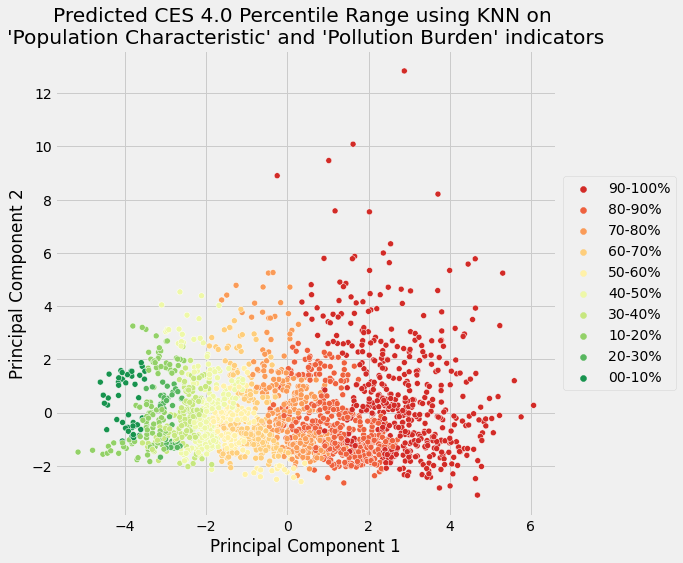

In [87]:
# Prediction visualization

prediction_visualization(knn_indicators, "'Population Characteristic' and 'Pollution Burden' indicators")

### Classification using 'Population Characteristic' indicators

79

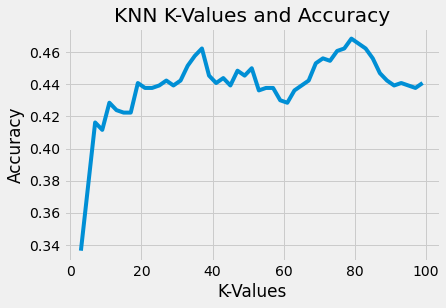

In [45]:
# Examine KNN accuracy with k

knn_train_test_k(pca_population)

### Classification using 'Pollution Burden' indicators

21

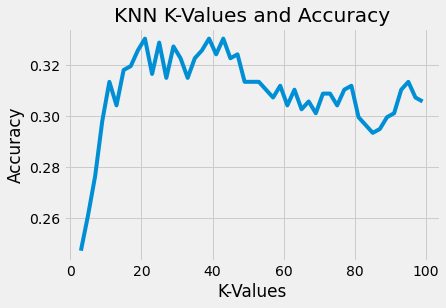

In [46]:
# Examine KNN accuracy with k

knn_train_test_k(pca_pollution)